# Advanced Lane Finder

## Camera Calibration

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

# Load the calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Chessboard size
nx = 9
ny = 6

objpoints = []
imgpoints = []

# Get obj and img points for each calibration img
for img_name in cal_images:
    img = mpimg.imread(img_name)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    if ret == True:
        cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        imgpoints.append(corners)
        objpoints.append(objp)

        

def undistort_img(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[0:2], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

## Gradient Threshold Functions

In [2]:
# An image threshold based on a singel sobel direction
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if(orient == 'x'):
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sbinary

# An image threshold based on the magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
     # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# An image threshold based on the combined sobel gradient direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output
    
# An image threshold based only on the saturation channel
def hls_sat_threshold(img,thresh = (180,255)):
    #Convert to HLS
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s_chan = hls[:,:,2]
    color_binary = np.zeros_like(s_chan)
    
    # Apply specified binary threshold and return the result
    color_binary[(s_chan > thresh[0]) & (s_chan <=thresh[1])] = 1
    
    return color_binary

# An image threshold based on only the red channel
def red_threshold(img, thresh = (200,255)):
    red_chan = img[:,:,1]
    
    red_binary = np.zeros_like(red_chan)
    red_binary[(red_chan < thresh[1]) & (red_chan >=thresh[0])] = 1
    return red_binary

## Fitting Lane Lines

In [3]:
def fit_lane_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 3/50 # meters per pixel in y
    xm_per_pix = 3.7/900

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
     # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    #Calculate how far the vehicle is from the center. 
    left_line_pos = left_fit[2]
    right_line_pos = right_fit[2]
    lane_middle = right_line_pos - left_line_pos
    car_pos = binary_warped.shape[1]/2

    car_off_center = (lane_middle - car_pos) * xm_per_pix
    
    curvature = ((left_curverad+right_curverad)/2.0)

    return left_fit,right_fit,curvature,car_off_center

def fit_lines_with_last(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit,right_fit,curvature

In [4]:
import cv2 as cv
def add_text(img,text,position):
    font = cv.FONT_HERSHEY_SIMPLEX
    cv.putText(img, text, position, font, 2.0, (255, 255, 255), 4, cv.LINE_AA)
    return img

## Threshold Image

In [5]:
"""  Function that takes as input the path to an image containing lane lines and returns as 
     output an the same image annotated with lane lines. 
"""
def find_lane(dist_img):   
    #Undistort using the camera calibration points
    undist_img = undistort_img(dist_img,objpoints,imgpoints)

    # Apply a combination of thresholds to maximize the line's visibility
    ksize = 11
    gradx = abs_sobel_thresh(undist_img, orient='x',thresh_min=25,thresh_max=255)
    grady = abs_sobel_thresh(undist_img, orient='y',thresh_min=25,thresh_max=255)
    s_binary = hls_sat_threshold(undist_img,thresh = (180,255))
    red_binary = red_threshold(undist_img,thresh = (200,255))

    # Create a combo using both the red channel and the saturation channel
    color_combo = np.zeros_like(s_binary)
    color_combo[(s_binary == 1) | (red_binary == 1)] = 1

    # Combine color_combination with gradx and grady thresholds
    combined = np.zeros_like(s_binary)
    combined[((gradx == 1) & (grady == 1)) | (color_combo == 1)] = 1

    # Set up points for perspective transform. Assumes ground is flat ahead
    warped_points = np.float32([[300,655],[1005,655],[685,450],[595,450]])
    dest_points = np.float32([[200,680],[1000,680],[1000,0],[200,0]])

    # Get perspective and inverse persepctive transform matrices
    M = cv2.getPerspectiveTransform(warped_points, dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,warped_points)

    # Warp perspective to birds eye view
    binary_warped = cv2.warpPerspective(combined,M,(combined.shape[1],combined.shape[0]))

    # Fit lane lines to image
    left_fit, right_fit,curvature,car_off_center = fit_lane_lines(binary_warped)

    # Generate values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    curvature_string = "Curvature Radius: %.2f" % curvature
    off_string = ("Vehicle is " + "%.2f" % car_off_center + "m off of center.")
    
    final = add_text(result,curvature_string,(50,50))
    final = add_text(result,off_string,(50,100))

    return final


## Process Single Image

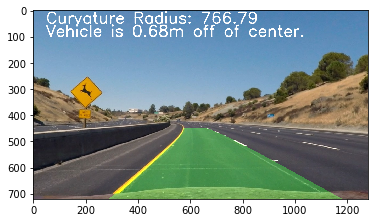

In [6]:
import matplotlib.image as mpimg
%matplotlib inline

dist_img = mpimg.imread('test_images/test2.jpg')
lanes_found = find_lane(dist_img)

plt.imshow(lanes_found)

## Load Video and Process

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Load Video, process each image to find lane and save video output
video_file = 'project_video.mp4'
video_clip = VideoFileClip(video_file)
clip = video_clip.fl_image(find_lane)
%time clip.write_videofile('project_video_output.mp4', audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [54:59<00:02,  2.34s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 39min 45s, sys: 28.5 s, total: 1h 40min 13s
Wall time: 55min 1s
